# (1) Multivariate Hawkes marked Process (volume) estimation processes for alpha, beta and mu

In [1]:
import numpy as np
from numba import njit

# ------------------------------------------------------------ #
# simulate the marked hawkess
# ------------------------------------------------------------ #

@njit
def simulate_marked_hawkes_numba(mu, alpha, beta, marks_array, T=50.0, max_events=100000):
    """
    Simulate multivariate marked Hawkes with exponential kernels using memory h[i,j]:
      lambda_i(t) = mu[i] + sum_j alpha[i,j] * h[i,j](t)
    where h[i,j](t) = sum_{k: event type j at t_k < t} mark_k * exp(-beta[i,j]*(t - t_k))
    marks_array: pre-sampled shape (max_events, d) or (max_events, ) for d=1
    Returns: events, types, marks_used
    """
    d = len(mu)
    t = 0.0
    events = np.zeros(max_events, dtype=np.float64)
    types = np.zeros(max_events, dtype=np.int64)
    marks = np.zeros(max_events, dtype=np.float64)

    # memory h[i,j]
    h = np.zeros((d, d), dtype=np.float64)

    # current intensity lambda_i
    lambda_t = mu.copy()
    lambda_bar = np.sum(lambda_t) + np.sum(alpha)  # Poisson thinning upper bound

    idx = 0
    rng = np.random

    while t < T and idx < max_events:
        u = rng.rand()
        d_rand = rng.rand()
        # next candidate
        w = -np.log(u) / lambda_bar
        t_candidate = t + w
        if t_candidate > T:
            break

        # Advance memory h by time w: h[i,j] *= exp(-beta[i,j] * w)
        # Also recompute lambda_t = mu + sum_j alpha[:,j] * h[:,j]
        for i in range(d):
            for j in range(d):
                b = beta[i, j]
                if b > 0.0:
                    h[i, j] *= np.exp(-b * w)
                # else b==0 -> no decay

        # recompute lambda_t
        for i in range(d):
            s = mu[i]
            for j in range(d):
                s += alpha[i, j] * h[i, j]
            lambda_t[i] = s

        lambda_sum = 0.0
        for i in range(d):
            lambda_sum += lambda_t[i]

        if d_rand * lambda_bar <= lambda_sum:
            # accept candidate: choose type
            # compute probs
            acc = 0.0
            r = rng.rand() * lambda_sum
            chosen = 0
            for i in range(d):
                acc += lambda_t[i]
                if r <= acc:
                    chosen = i
                    break

            # obtain mark for this event (for its type) from marks_array
            # we use idx as index into pre-sampled marks for accepted events
            mark = marks_array[idx, chosen]

            # record event
            events[idx] = t_candidate
            types[idx] = chosen
            marks[idx] = mark

            # update memory h: for all i, h[i, chosen] += mark
            for i in range(d):
                h[i, chosen] += mark

            idx += 1

        # update lambda_bar (upper bound) and time
        # recompute lambda_t and lambda_bar to be safe
        for i in range(d):
            s = mu[i]
            for j in range(d):
                s += alpha[i, j] * h[i, j]
            lambda_t[i] = s

        lambda_bar = np.sum(lambda_t) + np.sum(alpha)  # still a simple upper bound
        t = t_candidate

    return events[:idx], types[:idx], marks[:idx]



# ----------------------------------------------------------------- #
# loglik multivariate hawkes volume marked for mu, alpha and beta
# ----------------------------------------------------------------- #

@njit
def loglik_multivariate_hawkes_marked(mu, alpha, beta, events, types, marks, T):
    """
    Multivariate Hawkes log-likelihood with multiplicative marks.
    params:
      - mu:   (d,)        baseline intensities
      - alpha:(d,d)       excitation matrix
      - beta: (d,d)       decay rates (>=0)
      - events: (N,)      sorted event times (float)
      - types:  (N,)      integer event types in {0,..,d-1}
      - marks:  (N,)      float marks (e.g. volumes) aligned with events
      - T:      float     observation window end
    returns:
      logL - integral (float)
    """
    d = len(mu)
    N = len(events)

    # quick validation
    if len(types) != N or len(marks) != N:
        return -np.inf

    logL = 0.0
    integral = 0.0

    # memory for past contributions: h[i,j] = sum_k mark_k * exp(-beta[i,j]*(t - t_k))
    h = np.zeros((d, d), dtype=np.float64)

    t_prev = 0.0

    for n in range(N):
        t_n = events[n]
        dt = t_n - t_prev
        if dt < 0.0:
            return -np.inf

        # compensator increment over (t_prev, t_n)
        if dt > 0.0:
            integral += np.sum(mu) * dt
            for i in range(d):
                for j in range(d):
                    hij = h[i, j]
                    if hij == 0.0:
                        continue
                    b = beta[i, j]
                    if b > 0.0:
                        dec = np.exp(-b * dt)
                        integral += alpha[i, j] * hij * (1.0 - dec) / b
                    else:
                        integral += alpha[i, j] * hij * dt

        # decay memory to t_n
        for i in range(d):
            for j in range(d):
                b = beta[i, j]
                if b > 0.0:
                    h[i, j] *= np.exp(-b * dt)
                # if b == 0, no change

        # intensity at time t_n
        typ = int(types[n])
        lam = mu[typ]
        for j in range(d):
            lam += alpha[typ, j] * h[typ, j]

        if lam <= 0.0:
            return -np.inf
        logL += np.log(lam)

        # add this event's immediate (marked) jump to memory
        mark_n = marks[n]
        for i in range(d):
            h[i, typ] += mark_n

        t_prev = t_n

    # final compensator (t_last, T)
    dt = T - t_prev
    if dt < 0.0:
        return -np.inf
    if dt > 0.0:
        integral += np.sum(mu) * dt
        for i in range(d):
            for j in range(d):
                hij = h[i, j]
                if hij == 0.0:
                    continue
                b = beta[i, j]
                if b > 0.0:
                    dec = np.exp(-b * dt)
                    integral += alpha[i, j] * hij * (1.0 - dec) / b
                else:
                    integral += alpha[i, j] * hij * dt

    return logL - integral

# ------------------------------------------------------------------------- #
# loglik multivariatehawkes Elastic Net Penalization Function
# ------------------------------------------------------------------------- #

@njit
def loglik_multivariate_hawkes_elasticnet_marked(
    mu, alpha, beta, events, types, marks, T,
    lambda_mu=1e-3,
    lambda_alpha_l1=1e-3,
    lambda_alpha_l2=1e-3,
    lambda_beta_l2=1e-3
):
    """
    Penalized log-likelihood for multivariate Hawkes process with elastic-net regularization.
    Compatible with Numba and optimized for speed.
    """
    # Base log-likelihood (assumed JIT-compiled)
    ll = loglik_multivariate_hawkes_marked(mu, alpha, beta, events, types, marks, T)

    # --- Regularization penalties ---
    # Small epsilon to avoid division by zero in 1/mu
    eps = 1e-12

    # Vectorized penalty terms (Numba supports these operations efficiently)
    inv_mu = lambda_mu * np.sum(1.0 / (mu + eps))
    l1_alpha = lambda_alpha_l1 * np.sum(np.abs(alpha))
    l2_alpha = lambda_alpha_l2 * np.sum(alpha * alpha)
    l2_beta = lambda_beta_l2 * np.sum(beta * beta)

    penalty = inv_mu + l1_alpha + l2_alpha + l2_beta

    return ll - penalty  # maximize penalized likelihood

# -------------------------------------------------------------- # 
# estimate multivariate hawkes parameters mu, alpha and beta.
# -------------------------------------------------------------- #

def estimate_multivariate_hawkes_elasticnet_marked(events, types, marks, d, T,
                                            mu_init=None, alpha_init=None, beta_init=None,
                                            lambda_mu=1e-3, lambda_alpha_l1=1e-3,
                                            lambda_alpha_l2=1e-3, lambda_beta_l2=1e-3,
                                            maxiter=500):

    events = np.array(events)
    types = np.array(types)
    marks = np.array(marks)
    
    if mu_init is None:
        mu_init = np.ones(d) * 0.1
    if alpha_init is None:
        alpha_init = np.ones((d,d)) * 0.05
    if beta_init is None:
        beta_init = np.ones((d,d)) * 1.0

    params_init = np.concatenate([mu_init, alpha_init.flatten(), beta_init.flatten()])

    # Bounds to keep all parameters positive
    bounds = [(1e-5, None)] * d + [(0, None)] * (d*d) + [(1e-5, None)] * (d*d)

    # Objective for minimization (negative penalized likelihood)
    def objective(params):
        mu = params[:d]
        alpha = params[d:d+d*d].reshape((d,d))
        beta = params[d+d*d:].reshape((d,d))
        return -loglik_multivariate_hawkes_elasticnet_marked(mu, alpha, beta, events, types, marks, T,
                                                       lambda_mu, lambda_alpha_l1,
                                                       lambda_alpha_l2, lambda_beta_l2)

    res = minimize(objective, params_init, method='L-BFGS-B', bounds=bounds,
                   options={'disp': True, 'maxiter': maxiter})

    mu_est = res.x[:d]
    alpha_est = res.x[d:d+d*d].reshape((d,d))
    beta_est = res.x[d+d*d:].reshape((d,d))

    return mu_est, alpha_est, beta_est, res

## (1.1) Multivariate Hawkess LOB Level-I data processing 

### variables from the data:
- isBuyerMaker: True if the buyer was the maker, meaning the seller was the taker (aggressor). False if the buyer was the taker, meaning the buyer was the one who sent the market order and “hit” the book. meaning the market order came from the sell side.


In [2]:
import json
import pandas as pd
import numpy as np
import os
from datetime import datetime
import asyncio
import nest_asyncio
import ipaddress
from bson import json_util
import pymongo
from datetime import datetime, timedelta
from statistics import mean, stdev

MatchTrade_data = os.listdir("Data/MatchTrades")
MatchTrade_data = [f for f in MatchTrade_data if f != '.ipynb_checkpoints']
#print(MatchTrade_data)

LOB_data = os.listdir("Data/LOB")
LOB_data = [f for f in LOB_data if f != '.ipynb_checkpoints']
#print(LOB_data)

with open("Data/MatchTrades/"+MatchTrade_data[0]) as f:
    MatchTrade_data = pd.read_json(f)
    MatchTrade_data["timestamp"] = pd.to_datetime(MatchTrade_data["timestamp"], unit='ms')
    MatchTrade_data["trade"] = MatchTrade_data[["qty","price","isBuyerMaker","isBestMatch"]].values.tolist()
    MatchTrade_data["item"] = "match trade"
    MatchTrade_data = MatchTrade_data[["timestamp","item","trade"]]

"""
with open("Data/LOB/"+LOB_data[0]) as f:
    LOB_data = pd.read_json(f)
    LOB_data["timestamp"] = pd.to_datetime(LOB_data["timestamp"], unit='ms')
    LOB_data["item"] = "lob"
    LOB_data["lob snapshot"] = LOB_data[["bids","asks"]].values.tolist()
    LOB_data = LOB_data[["timestamp","item","lob snapshot"]]
"""

#merged1 = pd.merge(MatchTrade_data, LOB_data, on=["timestamp","item"], how="outer").sort_values("timestamp")
merged1 = MatchTrade_data.sort_values("timestamp")
merged = merged1

## (1.2) make aggregated events with marks

In [3]:
import pandas as pd
import numpy as np

def make_aggregated_events_with_marks(data):
    """
    Converts a DataFrame of trades into aggregated events and marks for a marked multivariate Hawkes process.
    
    Aggregates multiple trades at the same timestamp, separately for buy and sell, summing their volumes.

    Expects columns:
        - 'timestamp' : datetime
        - 'item'      : string, e.g., 'match trade'
        - 'trade'     : list/tuple, where index 3 indicates buy=True / sell=False
        - 'volume'    : numeric
    
    Returns:
        - times_list : list of np.arrays [buy_times, sell_times]
        - marks_list : list of np.arrays [buy_marks, sell_marks]
    """
    
    if not isinstance(data, pd.DataFrame):
        raise TypeError("data is not a pd.DataFrame")
    
    # Keep only match trades
    df = pd.DataFrame(data['trade'].tolist(), index=data.index)
    df.columns = ['volume', 'price', 'is_buy', 'is_market_order']
    
    # Add 'side' and 'volume' columns
    df['side'] = df['is_buy'].apply(lambda x: 'sell' if x else 'buy')
    
    # Default volume if missing
    df['volume'] = df.get('volume', 0.0)

    # Subtract first timestamp to start at 0
    first_time = data['timestamp'].iloc[0].timestamp()
    df['t'] = data['timestamp'].apply(lambda x: x.timestamp() - first_time)

    # Aggregate by timestamp and side
    agg = df.groupby(['t','side'], as_index=False)['volume'].sum()
    
    # Separate buy and sell events
    buy = agg[agg['side']=='buy'].sort_values('t')
    sell = agg[agg['side']=='sell'].sort_values('t')
    
    times_list = [buy['t'].to_numpy(dtype=float), sell['t'].to_numpy(dtype=float)]
    marks_list = [buy['volume'].to_numpy(dtype=float), sell['volume'].to_numpy(dtype=float)]
    
    return times_list, marks_list

In [4]:
times_list,marks_list = make_aggregated_events_with_marks(merged)
print(marks_list)

[array([2.000e-04, 2.697e-02, 1.040e-03, ..., 7.000e-05, 2.060e-03,
       4.100e-04]), array([8.00e-04, 7.20e-04, 2.40e-04, ..., 1.66e-03, 4.40e-01, 4.00e-04])]


In [5]:
import numpy as np
import pandas as pd
from scipy import stats

distributions = [
    stats.norm,
    stats.lognorm,
    stats.expon,
    stats.gamma,
    stats.beta  # beta requires data scaled between 0 and 1
]

data = np.concatenate([marks_list[0], marks_list[1]])

results = []

for dist in distributions:
    try:
        # Fit distribution to data
        params = dist.fit(data)
        
        # Compute log-likelihood
        ll = np.sum(dist.logpdf(data, *params))
        
        # Number of parameters
        k = len(params)
        
        # Compute AIC and BIC
        n = len(data)
        aic = 2*k - 2*ll
        bic = k*np.log(n) - 2*ll
        
        results.append({
            'Distribution': dist.name,
            'LogLikelihood': ll,
            'AIC': aic,
            'BIC': bic,
            'Parameters': params
        })
    except Exception as e:
        print(f"Could not fit {dist.name}: {e}")

/home/erick/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


In [6]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='AIC')  # lower AIC = better fit
print(results_df)

  Distribution  LogLikelihood            AIC            BIC  \
1      lognorm  411590.776170 -823175.552341 -823147.219782   
2        expon  246821.504160 -493639.008321 -493620.119948   
4         beta    2128.670553   -4249.341106   -4211.564361   
0         norm  -27036.766590   54077.533180   54096.421553   
3        gamma  -46319.003789   92644.007578   92672.340137   

                                          Parameters  
1  (2.216097249370343, 9.991430340163193e-06, 0.0...  
2                      (1e-05, 0.026151578885354066)  
4  (2568.036854301514, 481123015.883547, -8.48457...  
0         (0.026161578885354066, 0.3232490090151616)  
3  (0.0008270680671375434, 9.999999999999999e-06,...  


## (1.3) estimation of the parameters

In [7]:
import numpy as np
from scipy.optimize import minimize

buy_times, sell_times = times_list
buy_marks, sell_marks = marks_list

events = np.concatenate([buy_times, sell_times])
types  = np.concatenate([
    np.zeros(len(buy_times), dtype=np.int64),
    np.ones(len(sell_times), dtype=np.int64)
])
marks  = np.concatenate([buy_marks, sell_marks])

order = np.argsort(events)
events = events[order]
types  = types[order]
marks  = marks[order]

T = events.max()  # or some fixed observation window

d = 2

events = np.asarray(events, dtype=np.float64)
types  = np.asarray(types, dtype=np.int64)
marks  = np.asarray(marks, dtype=np.float64)
marks_scaled = (marks / np.mean(marks)) ** 0.5

# Estimate parameters
mu_hat, alpha_hat, beta_hat, res = estimate_multivariate_hawkes_elasticnet_marked(
    events, types, marks_scaled, d, T,
    lambda_mu=1e-3, lambda_alpha_l1=1e-3, lambda_alpha_l2=1e-3, lambda_beta_l2=1e-3,
    maxiter=1000
)

print("Estimated mu:", mu_hat)
print("Estimated alpha:\n", alpha_hat)
print("Estimated beta:\n", beta_hat)

Estimated mu: [1.64485625 1.63551065]
Estimated alpha:
 [[26.55211755  1.21023497]
 [ 0.2240992  19.80741076]]
Estimated beta:
 [[46.51009627 38.64049886]
 [ 7.84985177 47.37869398]]


In [8]:
G = alpha_hat / beta_hat
rho = np.max(np.abs(np.linalg.eigvals(G)))
print("Spectral radius:", rho)

Spectral radius: 0.5765318020092137


In [9]:
eta = np.sum(alpha_hat / beta_hat, axis=1)
print("Branching ratio per dimension:", eta)

Branching ratio per dimension: [0.6022097  0.44661399]


## (1.4) Time-Rescaling Theorem for Hawkes Processes

[-6.702158769939136, -6.467186243654785]
[2.167719382333747, 2.178834269329586]
Simulated 225 events up to time 50.0
Component 0: n=112, KS p=0.0392


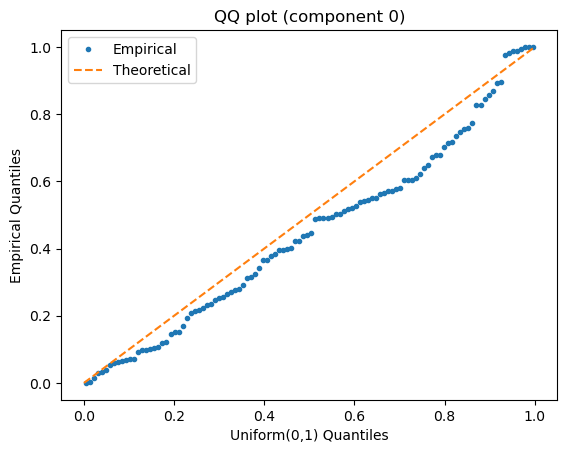

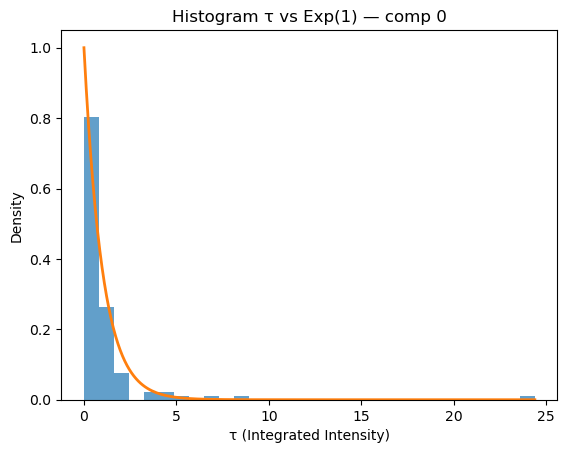

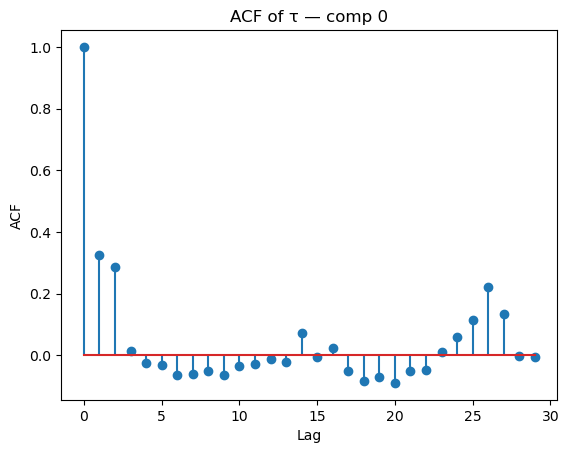

Component 1: n=113, KS p=0.0347


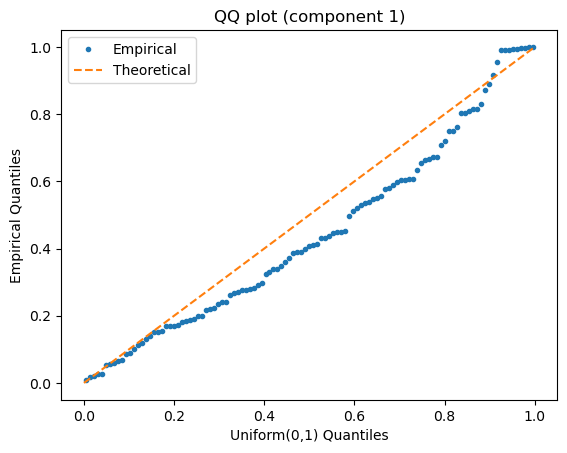

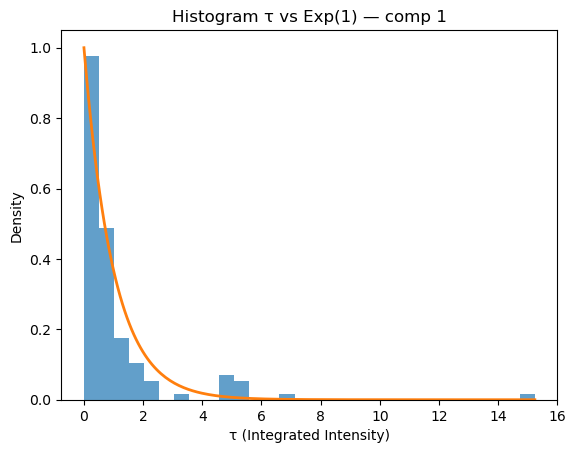

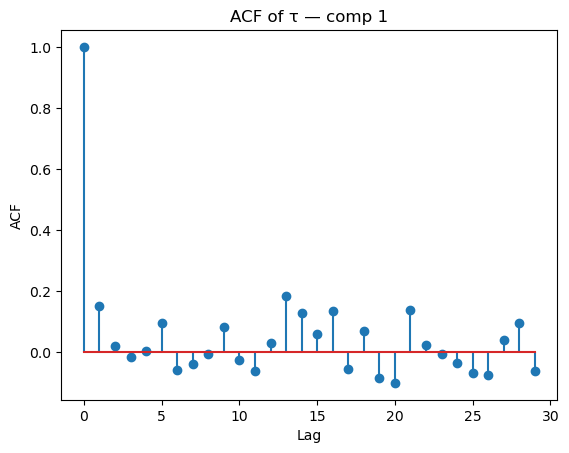

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest, expon
from numba import njit

import numpy as np
from scipy.stats import kstest

def diagnostics_time_rescaling_marked(events, types, marks, mu_hat, alpha_hat, beta_hat, d):
    """
    Time-rescaling diagnostic for marked multivariate Hawkes process.
    
    Parameters
    ----------
    events : array-like, shape (N,)
        Event times (sorted)
    types : array-like, shape (N,)
        Event types in {0,..,d-1}
    marks : array-like, shape (N,)
        Event marks (volume or dollar)
    mu_hat : array-like, shape (d,)
        Baseline intensities
    alpha_hat : array-like, shape (d,d)
        Excitation matrix
    beta_hat : array-like, shape (d,d)
        Decay rates
    d : int
        Number of dimensions

    Returns
    -------
    result : dict
        For each dimension k:
            - "taus": rescaled inter-event times
            - "u": uniform-transformed taus
            - "ks_stat": KS statistic
            - "ks_pvalue": KS p-value
    """
    
    N = len(events)
    events = np.asarray(events)
    types = np.asarray(types, dtype=int)
    marks = np.asarray(marks)
    
    h = np.zeros((d, d), dtype=np.float64)  # memory of past contributions
    last_time = 0.0
    taus = {k: [] for k in range(d)}
    
    for n in range(N):
        t_n = events[n]
        dt = t_n - last_time
        
        # decay memory
        for i in range(d):
            for j in range(d):
                if beta_hat[i, j] > 0:
                    h[i, j] *= np.exp(-beta_hat[i, j] * dt)
        
        # integral of intensity between last_time and t_n for each dimension
        integral = np.zeros(d)
        for i in range(d):
            integral[i] += mu_hat[i] * dt
            for j in range(d):
                if h[i, j] > 0:
                    b = beta_hat[i, j]
                    integral[i] += alpha_hat[i, j] * h[i, j] * (1 - np.exp(-b * dt)) / b if b > 0 else alpha_hat[i, j] * h[i, j] * dt
        
        # store rescaled time for this event
        typ = types[n]
        taus[typ].append(integral[typ])
        
        # update memory with new event (marked)
        mark_n = marks[n]
        for i in range(d):
            h[i, typ] += alpha_hat[i, typ] * mark_n  # multiplicative mark
        
        last_time = t_n
    
    # compute uniform variables and KS test
    result = {}
    for k in range(d):
        taus_k = np.array(taus[k])
        if len(taus_k) == 0:
            continue
        u = 1 - np.exp(-taus_k)  # transform exponential(1) → uniform(0,1)
        stat, pval = kstest(u, "uniform")
        result[k] = {"taus": taus_k, "u": u, "ks_stat": stat, "ks_pvalue": pval}
    
    return result

# ============================================================
# Step 3 — Plot diagnostics
# ============================================================
def plot_qq_uniform(u, title):
    u_sorted = np.sort(u)
    n = len(u_sorted)
    q = (np.arange(1, n + 1) - 0.5) / n
    plt.figure()
    plt.plot(q, u_sorted, ".", label="Empirical")
    plt.plot([0, 1], [0, 1], "--", label="Theoretical")
    plt.xlabel("Uniform(0,1) Quantiles")
    plt.ylabel("Empirical Quantiles")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_hist_tau(taus, title):
    plt.figure()
    plt.hist(taus, bins=30, density=True, alpha=0.7)
    x = np.linspace(0, max(5, taus.max()), 200)
    plt.plot(x, expon.pdf(x), lw=2)
    plt.title(title)
    plt.xlabel("τ (Integrated Intensity)")
    plt.ylabel("Density")
    plt.show()

def plot_acf(x, nlags=40, title=None):
    x = np.array(x)
    if len(x) <= 1:
        return
    x = x - x.mean()
    acf = np.correlate(x, x, mode="full")
    acf = acf[len(x)-1:]
    acf = acf / acf[0]

    # Ensure nlags doesn’t exceed available points
    nlags = min(nlags, len(acf))
    
    plt.figure()
    plt.stem(range(nlags), acf[:nlags])
    plt.title(title)
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.show()

# ============================================================
# Step 4 — Run demo
# ============================================================

if __name__ == "__main__":
    
    T = 50.0
    max_events = int(T)*1000
    d = 2

    # log-transform
    log_buy_marks = np.log(marks_list[0])
    log_sell_marks = np.log(marks_list[1]) 
    
    # estimate parameters
    mean = [np.mean(log_buy_marks),np.mean(log_sell_marks)] 
    sigma = [np.std(log_buy_marks, ddof=1),np.std(log_sell_marks, ddof=1)] 
    
    # unbiased estimator
    print(mean) 
    print(sigma) 
    
    marks_array = np.zeros((max_events, d))
    
    for i in range(d):
        marks_array[:, i] = np.random.lognormal(mean=mean[i], sigma=sigma[i], size=max_events) 
    
    marks_array_scaled = (marks_array / np.mean(marks_array)) ** 0.5
    marks_array_scaled = np.ascontiguousarray(marks_array_scaled, dtype=np.float64)
    
    # simulate
    events, types, marks_sim = simulate_marked_hawkes_numba(mu_hat, alpha_hat, beta_hat, 
                                                            marks_array_scaled, T=T, max_events=max_events,
                                                        )
    # Zip for diagnostics
    tuples = list(zip(events, types)) 
    tuples = sorted(tuples, key=lambda x: x[0])

    print(f"Simulated {len(events)} events up to time {T}")

    # Diagnostics
    res = diagnostics_time_rescaling_marked(events, types, marks_sim, mu_hat, alpha_hat, beta_hat, d)

    for k in [0, 1]:
        if k not in res:
            continue
        taus_k = res[k]["taus"]
        u_k = res[k]["u"]
        print(f"Component {k}: n={len(taus_k)}, KS p={res[k]['ks_pvalue']:.4f}")
        plot_qq_uniform(u_k, f"QQ plot (component {k})")
        plot_hist_tau(taus_k, f"Histogram τ vs Exp(1) — comp {k}")
        plot_acf(taus_k, 30, f"ACF of τ — comp {k}")